In [1]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
import numpy as np
import sklearn
from tqdm.auto import tqdm

In [2]:
# For visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
import pickle
from joblib import dump, load
import os

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold,train_test_split, RandomizedSearchCV
np.random.seed(42)

# Event Log & Data Loading

In [ ]:
# function to load the data from pickle
def load_data(load_path):
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [ ]:
data_test = load_data("../data/training_data/frequency_encode_test_trace_len_4.pickle")
data_train = load_data("../data/training_data/frequency_encode_train_trace_len_4.pickle")

# Model Building

## Scaling
If needed, would take place here. Not required for binary values.

In [ ]:
X_train = np.array(data_train['X'])
X_test = np.array(data_test['X'])
y_train = np.array(data_train['y'])
y_test = np.array(data_test['y'])

In [ ]:
# scaler_x = MinMaxScaler()
# data_scaled = scaler_x.fit_transform(data_dict['X'])

# scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
# target_scaled = scaler_y.fit_transform(data_dict['y'].reshape(-1, 1))

## Setting up Model Evaluation DataFrame
All the results will be saved to the `results_df` dataframe for comparison.

In [ ]:
results_df = pd.DataFrame(index=['Decision Tree (Default)'],
                          columns=['F-score', 'Precision','Recall', 'Accuracy'])

## Decision Tree Classifier

In [ ]:
# Create Decision Tree classifier object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifier
dt_fit = dt.fit(X_train,y_train)

#Predict the response for test dataset
dt_predict = dt_fit.predict(X_test)

results_df.loc['Decision Tree (Default)',:] = [f1_score(y_test,dt_predict, average='macro'), precision_score(y_test,dt_predict), recall_score(y_test,dt_predict),accuracy_score(y_test,dt_predict)]

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.476087,0.0,0.0,0.908714


[Text(0.8692660550458715, 0.9736842105263158, 'x[3] <= 0.5\ngini = 0.343\nsamples = 5596\nvalue = [4365, 1231]'),
 Text(0.7752293577981652, 0.9210526315789473, 'x[5] <= 0.5\ngini = 0.363\nsamples = 4967\nvalue = [3783, 1184]'),
 Text(0.6788990825688074, 0.868421052631579, 'x[20] <= 0.5\ngini = 0.34\nsamples = 3531\nvalue = [2764, 767]'),
 Text(0.5779816513761468, 0.8157894736842105, 'x[2] <= 0.5\ngini = 0.345\nsamples = 3460\nvalue = [2694, 766]'),
 Text(0.43119266055045874, 0.7631578947368421, 'x[24] <= 0.5\ngini = 0.34\nsamples = 3389\nvalue = [2652, 737]'),
 Text(0.3119266055045872, 0.7105263157894737, 'x[9] <= 0.5\ngini = 0.373\nsamples = 1045\nvalue = [786, 259]'),
 Text(0.26605504587155965, 0.6578947368421053, 'x[15] <= 0.5\ngini = 0.405\nsamples = 517\nvalue = [371, 146]'),
 Text(0.24770642201834864, 0.6052631578947368, 'x[6] <= 0.5\ngini = 0.412\nsamples = 496\nvalue = [352, 144]'),
 Text(0.21100917431192662, 0.5526315789473685, 'x[21] <= 0.5\ngini = 0.405\nsamples = 468\nvalue

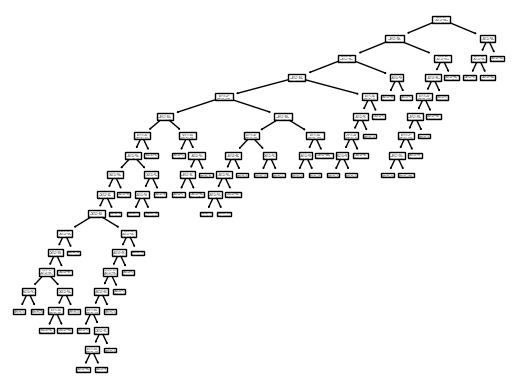

In [ ]:
tree.plot_tree(dt_fit)

# Logistic Regression


In [ ]:
# Training the Logistic Regression model on the Training set
lr = LogisticRegression(random_state=42)
lr_fit = lr.fit(X_train, y_train)
# Predicting the Test set results
lr_predict = lr_fit.predict(X_test)

results_df.loc['Logistic Regression (Default)',:] = [f1_score(y_test,lr_predict, average='macro'), precision_score(y_test,lr_predict), recall_score(y_test,lr_predict),accuracy_score(y_test,lr_predict)]

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.476087,0.0,0.0,0.908714
Logistic Regression (Default),0.476087,0.0,0.0,0.908714


In [ ]:
solvers = ['lbfgs','newton-cg','liblinear','sag','saga']
penalty = ['l2', 'None']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iteration= [100, 200, 500, 1000, 2000, 5000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iteration)

lr_grid = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
lr_grid_fit = lr_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression (Grid CV Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.476087,0.0,0.0,0.908714
Logistic Regression (Default),0.476087,0.0,0.0,0.908714
Logistic Regression (Grid CV Tuning),0.438209,0.390011,0.5,0.780022


In [47]:
import seaborn as sns

# Create a data frame with the evaluation metrics
df = pd.DataFrame({'Model': ['Decision Tree', 'Logistic Regression (Default)', 'Logistic Regression (Grid CV Tuning)'],
                   'F-score': [0.476087, 0.476087, 0.438209],
                   'Precision': [0.0, 0.0, 0.390011],
                   'Recall': [0.0, 0.0, 0.5],
                   'Accuracy': [0.908714, 0.908714, 0.780022]})


Text(0.5, 1.0, 'Accuracy')

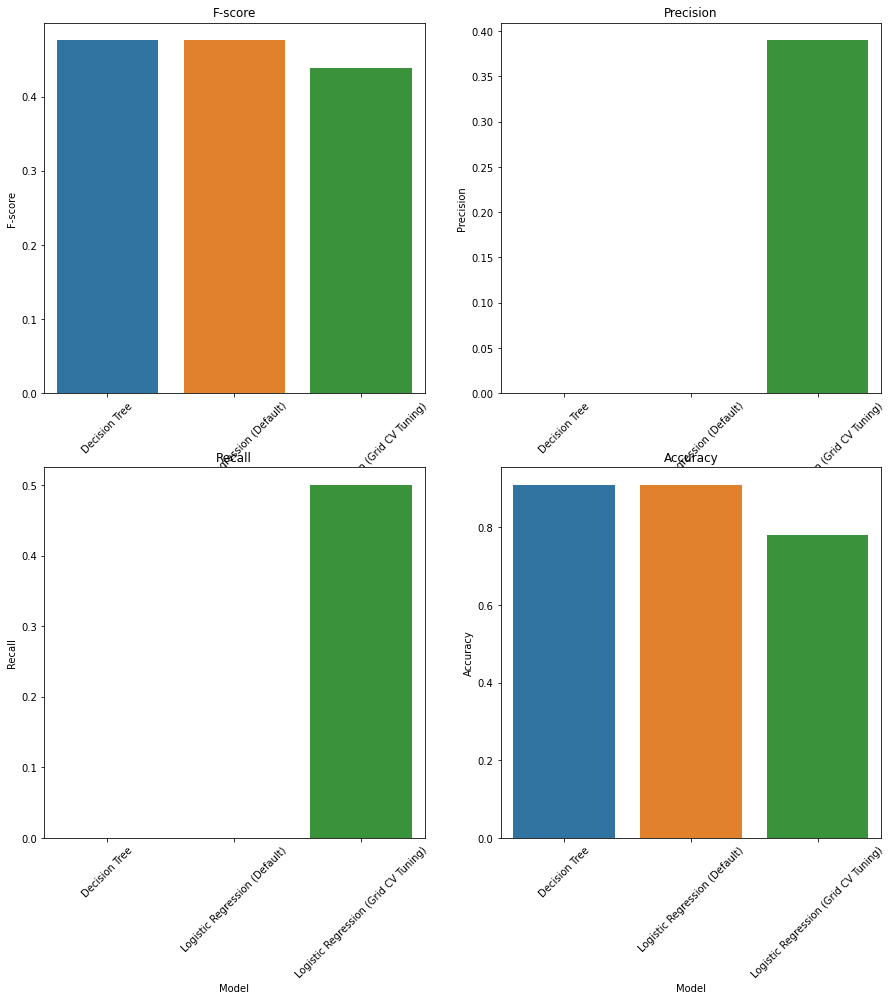

In [53]:
# Create the figure with subplots
fig, ax  = plt.subplots(2,2,figsize=(15,15))

# Plot the first bar plot
sns.barplot(x='Model', y='F-score', data=df, ax=ax[0,0])

# Set the axis label for the first subplot
ax[0,0].set_xlabel("Model")
ax[0,0].set_ylabel("F-score")

# Rotate the x-axis labels
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45)


# Add a title to the first subplot
ax[0,0].set_title("F-score")

# Plot the second bar plot
sns.barplot(x='Model', y='Precision', data=df, ax=ax[0,1])

# Set the axis label for the second subplot
ax[0,1].set_xlabel("Model")
ax[0,1].set_ylabel("Precision")

# Rotate the x-axis labels
ax[0,1].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45)

# Add a title to the second subplot
ax[0,1].set_title("Precision")

# Plot the third bar plot
sns.barplot(x='Model', y='Recall', data=df, ax=ax[1,0])

# Set the axis label for the third subplot
ax[1,0].set_xlabel("Model")
ax[1,0].set_ylabel("Recall")

# Rotate the x-axis labels
ax[1,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45)

# Add a title to the third subplot
ax[1,0].set_title("Recall")

# Plot the fourth bar plot
sns.barplot(x='Model', y='Accuracy', data=df, ax=ax[1,1])

# Set the axis label for the fourth subplot
ax[1,1].set_xlabel("Model")
ax[1,1].set_ylabel("Accuracy")

# Rotate the x-axis labels
ax[1,1].set_xticklabels(ax[0,0].get_xticklabels(), rotation=45)

# Add a title to the fourth subplot
ax[1,1].set_title("Accuracy")



# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
n_estimators = [1,5,10,40,100,200,500,1000,2000,5000]
max_features = ['sqrt', 'log2']
max_depth = [1,3,5,7,9,11,13,15,20]
criterion= ['gini', 'entropy']

grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)
rf_random_fit = rf_random.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(rf_random.best_estimator_ , X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Random Forest (Randomized Parameters)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


# MLP (Neural Network) Classifier

In [ ]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[1*i,1*i] for i in range(1,5)]
sizes = sizes + [[1*i,1*i, 1*i] for i in range(1,5)]

decays = [3,4,5,6,7,8]

nnet = MLPClassifier(alpha=0,
                     activation='logistic',
                           max_iter=500,
                           solver='lbfgs',
                           random_state=42)

nnet_grid = GridSearchCV(estimator=nnet,
                   scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays,},
                   return_train_score=True,
                   refit='f1_macro')

nnet_grid_fit = nnet_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(nnet_grid.best_estimator_, X_train, y_train, scoring = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP (Hyper Parameter Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

In [ ]:
print(nnet_grid.best_params_)
print(nnet_grid.best_estimator_.n_iter_)
print(nnet_grid.best_estimator_.n_layers_)

In [ ]:
def save_model(model, model_name, output_path):
    dump(model, os.path.join(output_path, model_name+'.joblib'))

In [ ]:
model_path = '../models'
save_model(dt_fit, 'dt_fit', model_path)
save_model(lr_fit, 'lr_fit', model_path)
save_model(lr_fit_grid, 'lr_fit_grid', model_path)
save_model(rf_random_fit, 'rf_random_fit', model_path)
save_model(nnet_grid_fit, 'nnet_grid_fit', model_path)